# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance (accuracy, precision, recall, and f-score) as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client for a any sepcific number of clients of your choice. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [2]:
np.random.seed(2324555) # Set seed for numpy. Put your SID instead of number '42'
random.seed(2324555) # Set seed for Python's built-in random number generator.  Put your SID instead of number '42'
tf.random.set_seed(2324555) # Set seed for TensorFlow. Put your SID instead of number '42'
K.clear_session()


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=1)
    return model

2 clients

In [7]:
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, random_state=2324555)



In [8]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)


(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [9]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)

D:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8298 - loss: 0.5898
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9510 - loss: 0.1788
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9661 - loss: 0.1226
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9750 - loss: 0.0906
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9811 - loss: 0.0682
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8451 - loss: 0.5489
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9504 - loss: 0.1740
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9652 - loss: 0.1184
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9759 - loss: 0.0855
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9837 - loss: 0.0632


In [10]:
# Federated averaging
def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [11]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [12]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)


In [13]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - 2ms/step - accuracy: 0.9228 - loss: 0.3132
Test accuracy: 0.9228000044822693


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [15]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)


In [16]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       980
           1       0.98      0.98      0.98      1135
           2       0.91      0.94      0.93      1032
           3       0.86      0.96      0.91      1010
           4       0.98      0.91      0.94       982
           5       0.78      0.91      0.84       892
           6       0.95      0.96      0.95       958
           7       0.89      0.96      0.92      1028
           8       0.96      0.86      0.91       974
           9       0.95      0.87      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



In [17]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))


Accuracy test set: 0.9228
precison test set: 0.9276216276598336
Recall test set: 0.9228
f-score test set: 0.9234451354651865


In [18]:
test_precision= []
test_recall = []
test_f1_score = []
test_accuracy=[]

In [19]:
test_accuracy.append(0.9163)
test_precision.append(0.9215082367337915)
test_recall.append(0.9163)
test_f1_score.append(0.9169298364166276)

In [20]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9163]
[0.9215082367337915]
[0.9163]
[0.9169298364166276]


4 clients

In [21]:
# split data into 4 clients

In [22]:
client_1 = (x_train[0:15000], y_train[0:15000])
client_2 = (x_train[15000:30000], y_train[15000:30000])
client_3 = (x_train[30000:45000], y_train[30000:45000])
client_4 = (x_train[45000:], y_train[45000:])


In [23]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [24]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])

Epoch 1/5


D:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7876 - loss: 0.7437
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9344 - loss: 0.2275
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9578 - loss: 0.1573
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9699 - loss: 0.1142
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9781 - loss: 0.0839
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1032 - loss: 2.3256
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1153 - loss: 2.2958
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1355 - loss: 2.2818
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1454 - loss: 2.2664
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1632 - loss: 2.2459
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1017 - loss: 2.3330
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1176 - los

In [25]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2,  weights3,  weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights

In [26]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights())

In [27]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - 2ms/step - accuracy: 0.3333 - loss: 2.2371
Test accuracy: 0.33329999446868896


In [28]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)


In [29]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.3333
precison test set: 0.4300590958187017
Recall test set: 0.3333
f-score test set: 0.2994137942681089


In [30]:
test_accuracy.append(0.3284)
test_precision.append(0.4848525535059179)
test_recall.append(0.3284)
test_f1_score.append(0.2975957444966415)

In [31]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9163, 0.3284]
[0.9215082367337915, 0.4848525535059179]
[0.9163, 0.3284]
[0.9169298364166276, 0.2975957444966415]


6 clients cell


In [32]:
client_1 = (x_train[0:10000], y_train[0:10000])
client_2 = (x_train[10000:20000], y_train[10000:20000])
client_3 = (x_train[20000:30000], y_train[20000:30000])
client_4 = (x_train[30000:40000], y_train[30000:40000])
client_5 = (x_train[40000:50000], y_train[40000:50000])
client_6 = (x_train[50000:], y_train[50000:])

In [33]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [34]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])
client5_model = train_client_model(client5_model, client_5[0], client_1[1])
client6_model = train_client_model(client6_model, client_6[0], client_1[1])

Epoch 1/5


D:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7653 - loss: 0.8474
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9266 - loss: 0.2681
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9484 - loss: 0.1893
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9624 - loss: 0.1435
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9729 - loss: 0.1130
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1020 - loss: 2.3350
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1220 - loss: 2.2915
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1426 - loss: 2.2711
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1622 - loss: 2.2482
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1925 - loss: 2.2159
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0982 - loss: 2.3347
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1331 - los

In [35]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2,  weights3,  weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights

In [36]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights(),client5_model.get_weights(),client6_model.get_weights())

In [37]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - 2ms/step - accuracy: 0.1504 - loss: 2.2963
Test accuracy: 0.15039999783039093


In [38]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)


In [39]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.1504
precison test set: 0.15463552696696992
Recall test set: 0.1504
f-score test set: 0.09640549205188623


In [40]:
test_accuracy.append(0.1518)
test_precision.append(0.15683234386034006)
test_recall.append(0.1518)
test_f1_score.append(0.12918649178542027)

In [41]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9163, 0.3284, 0.1518]
[0.9215082367337915, 0.4848525535059179, 0.15683234386034006]
[0.9163, 0.3284, 0.1518]
[0.9169298364166276, 0.2975957444966415, 0.12918649178542027]


8 clients


In [42]:
client_1 = (x_train[0:7500], y_train[0:7500])
client_2 = (x_train[7500:15000], y_train[7500:15000])
client_3 = (x_train[15000:22500], y_train[15000:22500])
client_4 = (x_train[22500:30000], y_train[22500:30000])
client_5 = (x_train[30000:37500], y_train[30000:37500])
client_6 = (x_train[37500:45000], y_train[37500:45000])
client_7 = (x_train[45000:52500], y_train[45000:52500])
client_8 = (x_train[52500:], y_train[52500:]) 

In [43]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)


In [44]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_2[1])
client3_model = train_client_model(client3_model, client_3[0], client_3[1])
client4_model = train_client_model(client4_model, client_4[0], client_4[1])
client5_model = train_client_model(client5_model, client_5[0], client_5[1])
client6_model = train_client_model(client6_model, client_6[0], client_6[1])
client7_model = train_client_model(client7_model, client_7[0], client_7[1])
client8_model = train_client_model(client8_model, client_8[0], client_8[1])

D:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7174 - loss: 0.9795
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9223 - loss: 0.2882
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - loss: 0.2096
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9558 - loss: 0.1594
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9675 - loss: 0.1240
Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7236 - loss: 0.9753
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.3010
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.2190
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1694
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1340
Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7207 - loss: 0.9744
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

In [45]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4,  weights5,  weights6,  weights7,  weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2,  weights3,  weights4,  weights5,  weights6,  weights7,  weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8) / 8)
    return new_weights

In [46]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), 
                                               client3_model.get_weights(), client4_model.get_weights(),  
                                               client5_model.get_weights(), client6_model.get_weights(), 
                                               client7_model.get_weights(), client8_model.get_weights())

In [47]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - 2ms/step - accuracy: 0.4210 - loss: 1.5526
Test accuracy: 0.42100000381469727


In [48]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)


In [49]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.421
precison test set: 0.6980246367138808
Recall test set: 0.421
f-score test set: 0.3697585244941951


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
test_accuracy.append(0.4921)
test_precision.append(0.7043790576459266)
test_recall.append(0.4921)
test_f1_score.append(0.45679406462004846)

In [51]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9163, 0.3284, 0.1518, 0.4921]
[0.9215082367337915, 0.4848525535059179, 0.15683234386034006, 0.7043790576459266]
[0.9163, 0.3284, 0.1518, 0.4921]
[0.9169298364166276, 0.2975957444966415, 0.12918649178542027, 0.45679406462004846]


10 clients

In [52]:
client_1 = (x_train[0:6000],y_train[0:6000])
client_2= (x_train[6000:12000],y_train[6000:12000])
client_3= (x_train[12000:18000],y_train[12000:18000])
client_4= (x_train[18000:24000], y_train[18000:24000])
client_5=(x_train[24000:30000], y_train[24000:30000])
client_6= (x_train[30000:36000], y_train[30000:36000])
client_7=(x_train[36000:42000], y_train[36000:42000])
client_8=(x_train[42000:48000], y_train[42000:48000])
client_9=(x_train[48000:54000], y_train[48000:54000])
client_10=(x_train[54000:],y_train[54000:])

In [53]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)
print(client_9[0].shape)
print(client_10[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)
print(client_9[1].shape)
print(client_10[1].shape)

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)


In [54]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_2[1])
client3_model = train_client_model(client3_model, client_3[0], client_3[1])
client4_model = train_client_model(client4_model, client_4[0], client_4[1])
client5_model = train_client_model(client5_model, client_5[0], client_5[1])
client6_model = train_client_model(client6_model, client_6[0], client_6[1])
client7_model = train_client_model(client7_model, client_7[0], client_7[1])
client8_model = train_client_model(client8_model, client_8[0], client_8[1])
client9_model = train_client_model(client8_model, client_9[0], client_9[1])
client10_model = train_client_model(client8_model, client_10[0], client_10[1])

D:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7166 - loss: 1.0388
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9201 - loss: 0.2905
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.2121
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9581 - loss: 0.1641
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9687 - loss: 0.1304
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6897 - loss: 1.0918
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9111 - loss: 0.3089
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2213
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9560 - loss: 0.1679
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9680 - loss: 0.1312
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6923 - loss: 1.0971
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

In [55]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4,  weights5,  weights6,  weights7,  weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2,  weights3,  weights4,  weights5,  weights6,  weights7,  weights8, weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights

In [56]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), 
                                               client3_model.get_weights(), client4_model.get_weights(),  
                                               client5_model.get_weights(), client6_model.get_weights(), 
                                               client7_model.get_weights(), client8_model.get_weights(),
                                               client9_model.get_weights(), client10_model.get_weights())
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)


In [57]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 - 1s - 2ms/step - accuracy: 0.7255 - loss: 1.1132
Test accuracy: 0.7254999876022339
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)


In [58]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

print(classification_report(y_test, prediction))

Accuracy test set: 0.7255
precison test set: 0.8574106113383166
Recall test set: 0.7255
f-score test set: 0.7089747664048425
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       980
           1       0.97      0.97      0.97      1135
           2       0.90      0.86      0.88      1032
           3       0.82      0.84      0.83      1010
           4       0.92      0.85      0.88       982
           5       0.32      0.98      0.48       892
           6       0.98      0.70      0.82       958
           7       0.69      0.96      0.80      1028
           8       0.99      0.17      0.29       974
           9       0.96      0.11      0.20      1009

    accuracy                           0.73     10000
   macro avg       0.85      0.72      0.70     10000
weighted avg       0.86      0.73      0.71     10000



In [59]:
test_accuracy.append(0.7529)
test_precision.append(0.8338354520257586)
test_recall.append(0.7529)
test_f1_score.append(0.7288177564972788)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.9163, 0.3284, 0.1518, 0.4921, 0.7529]
[0.9215082367337915, 0.4848525535059179, 0.15683234386034006, 0.7043790576459266, 0.8338354520257586]
[0.9163, 0.3284, 0.1518, 0.4921, 0.7529]
[0.9169298364166276, 0.2975957444966415, 0.12918649178542027, 0.45679406462004846, 0.7288177564972788]


Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.¶

In [60]:
import pandas as pd

In [61]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.9163, 0.3284, 0.1518, 0.4921, 0.7529], [0.9215082367337915, 0.4848525535059179, 0.15683234386034006, 0.7043790576459266, 0.8338354520257586], [0.9163, 0.3284, 0.1518, 0.4921, 0.7529], [0.9169298364166276, 0.2975957444966415, 0.12918649178542027, 0.45679406462004846, 0.7288177564972788]]


,Accuracy,Precision,Recall,F1_Score
2,0.9163,0.921508,0.9163,0.916930
4,0.3284,0.484853,0.3284,0.297596
6,0.1518,0.156832,0.1518,0.129186
8,0.4921,0.704379,0.4921,0.456794
10,0.7529,0.833835,0.7529,0.728818


<Axes: >

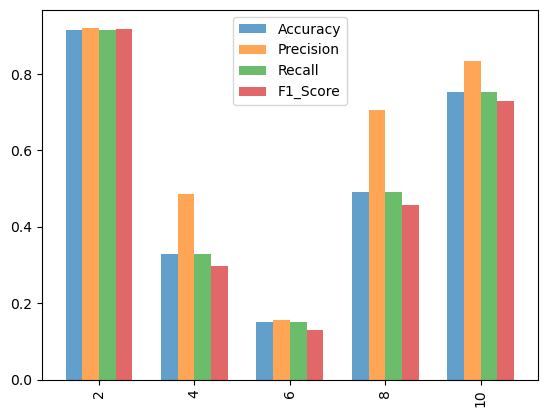

In [62]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

Dishonest 


In [63]:
# Split data into 4 clients
client_1 = (x_train[0:15000], y_train[0:15000])
client_2 = (x_train[15000:30000], y_train[15000:30000])
client_3 = (x_train[30000:45000], y_train[30000:45000])
client_4 = (x_train[45000:], y_train[45000:])

In [64]:
client_3[1].size

15000

In [65]:
client_3[1]

array([3, 7, 3, ..., 8, 4, 5], dtype=uint8)

In [66]:
client_3[1][:3000] = 5

In [67]:
client_3[1]

array([5, 5, 5, ..., 8, 4, 5], dtype=uint8)

In [68]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [69]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])

Epoch 1/5


D:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7817 - loss: 0.7493
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.2296
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9556 - loss: 0.1590
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9681 - loss: 0.1168
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9763 - loss: 0.0870
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0997 - loss: 2.3300
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1214 - loss: 2.2937
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1317 - loss: 2.2804
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1546 - loss: 2.2585
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1692 - loss: 2.2354
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1060 - loss: 2.3239
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1210 - los

In [70]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weights3, weights4):
        new_weights.append((w1 + w2 + w3 + w4 ) / 4)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights())
                                             
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [71]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - 2ms/step - accuracy: 0.2476 - loss: 2.2557
Test accuracy: 0.2476000040769577
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)
Accuracy test set:  0.2476
Precision test set:  0.3087339281190053
Recall test set:  0.2476
F-score test set:  0.21732400455516585
              precision    recall  f1-score   support

           0       0.59      0.02      0.03       980
           1       0.29      0.96      0.44      1135
           2       0.21      0.14      0.17      1032
           3       0.07      0.08      0.07      1010
           4       0.68      0.39      0.50       982
           5       0.48      0.36      0.41       892
           6       0.34      0.11      0.17       958
           7       0.08      0.12      0.10      1028
           8       0.29      0.15      0.20       974
           9       0.10      0.08      0.09      1009

    accuracy                           0.25     10000
   macro avg       0.31      0.24      0.22     10000
weighted avg       0

In [72]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [73]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.3603)
test_precision_dishonest.append(0.423169487718241)
test_recall_dishonest.append(0.3603)
test_f1_score_dishonest.append(0.3296364992938911)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.1518, 0.3603]
[0.15683234386034006, 0.423169487718241]
[0.1518, 0.3603]
[0.12918649178542027, 0.3296364992938911]


In [74]:
### Plot the model's performance for the 4 clients, one of them (number=3) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#3 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.1518, 0.3603], [0.15683234386034006, 0.423169487718241], [0.1518, 0.3603], [0.12918649178542027, 0.3296364992938911]]


,Accuracy,Precision,Recall,F1_Score
All are honest,0.1518,0.156832,0.1518,0.129186
#3 is dishonest,0.3603,0.423169,0.3603,0.329636


<Axes: >

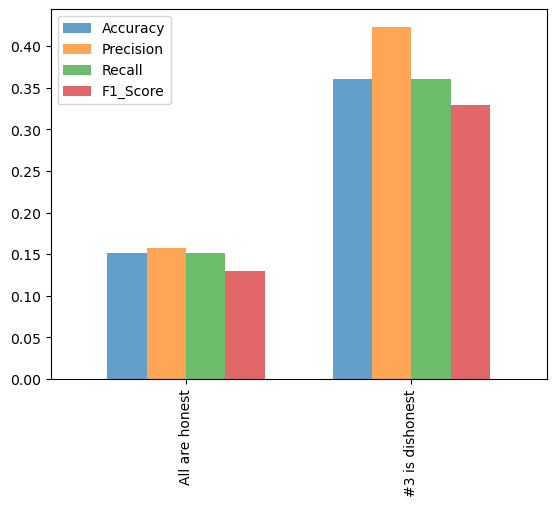

In [75]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

# Lab Logbook requirement: Document the following in lablogbook

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.




# Challenges (Optional):

## The above code is for one communication round. Write code for multiple communication rounds. In each communication round, clients will train the model on a new dataset. Then the server will merge all these models. Subsequently, the clients will retrain the merged model in the next communication round.

